In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.1815e-08, 1.6271e-07, 8.4173e-05, 2.6354e-08, 4.2877e-04, 4.2485e-06,
          3.1483e-06, 4.5915e-14, 7.7901e-06, 9.9947e-01]]),
 tensor([[0.0150, 0.0254, 0.0887, 0.0177, 0.1228, 0.0488, 0.0460, 0.0012, 0.0551,
          0.5792]]),
 tensor([[0.0485, 0.0630, 0.1177, 0.0525, 0.1385, 0.0873, 0.0848, 0.0139, 0.0928,
          0.3008]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

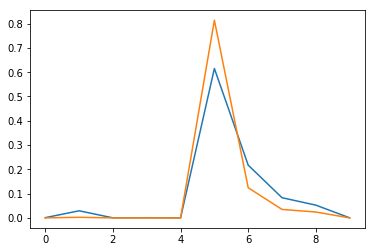

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [17]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1.h5'),EarlyStopping(10)])

1: Train=429.9869860839844 Valid=372.78731506347657
2: Train=359.68444061279297 Valid=352.8988397216797
3: Train=350.02498901367187 Valid=345.6790783691406
4: Train=343.40363525390626 Valid=340.56659240722655
5: Train=338.45992950439455 Valid=336.59108276367186
6: Train=334.76060974121094 Valid=332.28894287109375
7: Train=331.6452081298828 Valid=329.4747711181641
8: Train=329.03744415283205 Valid=326.2031024169922
9: Train=325.42691711425783 Valid=324.299697265625
10: Train=324.30385925292967 Valid=321.4197216796875
11: Train=322.1323263549805 Valid=319.0329833984375
12: Train=319.92156311035154 Valid=317.0141522216797
13: Train=318.5600308227539 Valid=314.79736389160155
14: Train=316.7531698608398 Valid=313.0703112792969
15: Train=315.097059173584 Valid=311.3639093017578
16: Train=313.5192416381836 Valid=309.6147131347656
17: Train=311.26775817871095 Valid=307.97979248046875
18: Train=310.17436111450195 Valid=306.4327679443359
19: Train=309.3385745239258 Valid=304.4966290283203
20: Tr

155: Train=241.70261322021486 Valid=241.0221405029297
156: Train=241.48189712524413 Valid=240.96077209472656
157: Train=241.0652978515625 Valid=240.90252655029298
158: Train=241.55756790161132 Valid=240.44132873535156
159: Train=241.08077682495116 Valid=240.7944821166992
160: Train=240.41702896118164 Valid=240.73914306640626
161: Train=240.43317932128906 Valid=240.5279769897461
162: Train=241.09737060546874 Valid=240.1882794189453
163: Train=240.4260368347168 Valid=240.46485198974608
164: Train=240.48640548706055 Valid=240.4769674682617
165: Train=240.43069442749024 Valid=239.87660522460936
166: Train=240.67288787841798 Valid=240.56270416259767
167: Train=239.9882389831543 Valid=240.22410858154296
168: Train=239.8876498413086 Valid=240.16143280029297
169: Train=240.29898620605468 Valid=240.16338195800782
170: Train=240.07534530639649 Valid=239.37669921875
171: Train=240.9483477783203 Valid=239.93231536865235
172: Train=240.8013887023926 Valid=239.7138720703125
173: Train=240.3097918701

In [18]:
model.save('weights/Inferno_Test_exact_bm1.h5')

In [17]:
model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

In [18]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [19]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [20]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,0,1.0
2,1,1.0
3,1,1.0
4,1,1.0


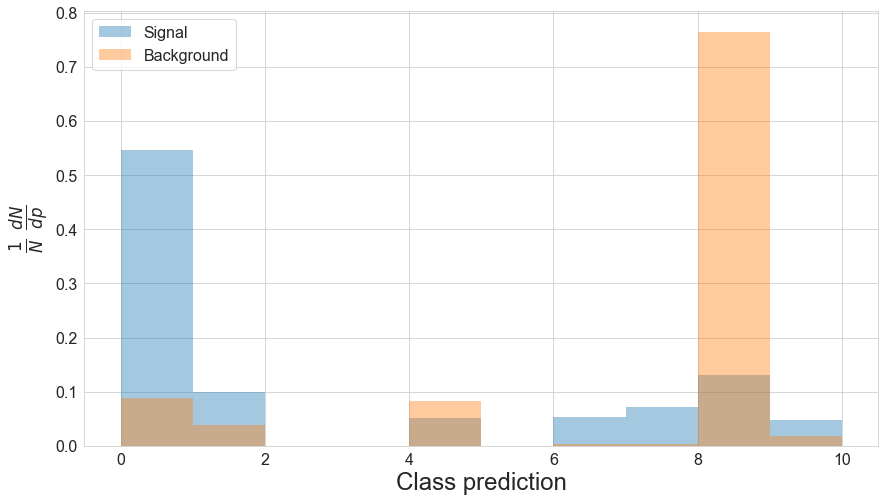

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [22]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,0,1.0,0
2,1,1.0,1
3,1,1.0,1
4,1,1.0,1


In [24]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [26]:
f_s, f_b

(tensor([5.4718e-01, 9.9526e-02, 2.0000e-13, 2.0000e-13, 5.0638e-02, 2.0000e-13,
         5.2914e-02, 7.0786e-02, 1.3047e-01, 4.8484e-02]),
 tensor([8.7744e-02, 3.8964e-02, 2.0000e-13, 2.0000e-13, 8.2094e-02, 2.0000e-13,
         3.0620e-03, 3.8900e-03, 7.6542e-01, 1.8826e-02]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([1.1510e+02, 4.3940e+01, 2.1000e-10, 2.1000e-10, 8.4626e+01, 2.1000e-10,
         5.7077e+00, 7.4293e+00, 7.7194e+02, 2.1250e+01]), tensor(1050.))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([21.80334091, 21.65449333, 21.51127243, 21.37447357, 21.24325752,
       21.11878777, 20.99956894, 20.88553619, 20.77753448, 20.67511368,
       20.57859802, 20.4869194 , 20.40052032, 20.3192749 , 20.2432003 ,
       20.17262268, 20.10663223, 20.04547882, 19.98917007, 19.93821716,
       19.89196777, 19.84988022, 19.8128624 , 19.77998352, 19.75205803,
       19.72859764, 19.70942688, 19.69421959, 19.68370628, 19.67795563,
       19.67594147, 19.67748833, 19.68359756, 19.69424629, 19.70846939,
       19.72654533, 19.74850845, 19.77441978, 19.80417824, 19.83862686,
       19.87583923, 19.91672325, 19.96131897, 20.01047134, 20.06219101,
       20.1174736 , 20.17677307, 20.23904037, 20.30573654, 20.37529564,
       20.44781494, 20.52415466, 20.6036377 , 20.68704605, 20.77311707,
       20.86242676, 20.95438766, 21.05051804, 21.1492424 , 21.25102234,
       21.35634804])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

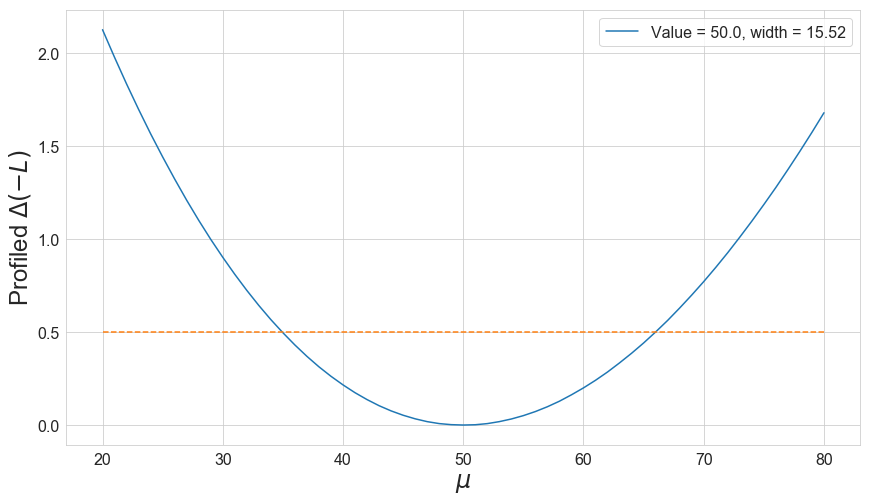

In [32]:
plot_likelihood(y-y.min())

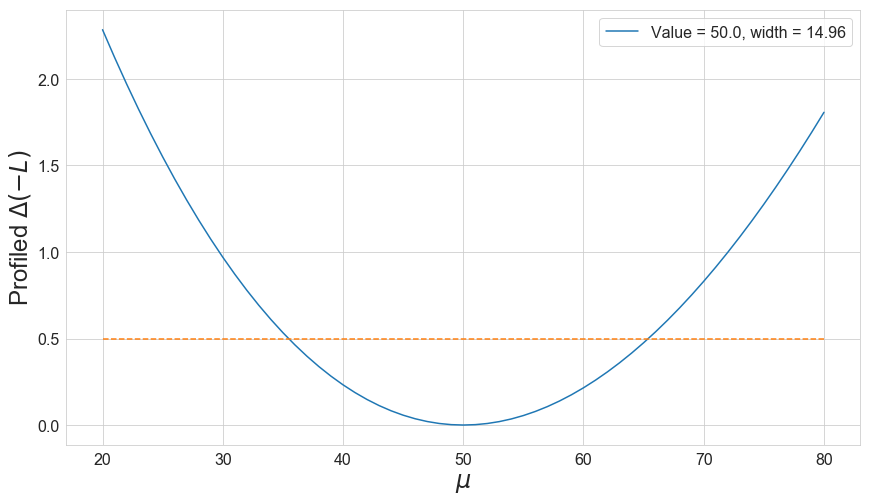

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [34]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [35]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,1,1.0,1,1,1,1,1,1,1,1,1,1,1
3,1,1.0,1,1,1,1,1,1,1,1,1,1,1
4,1,1.0,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999998,8,0.0,8,8,8,8,8,8,8,8,8,8,8


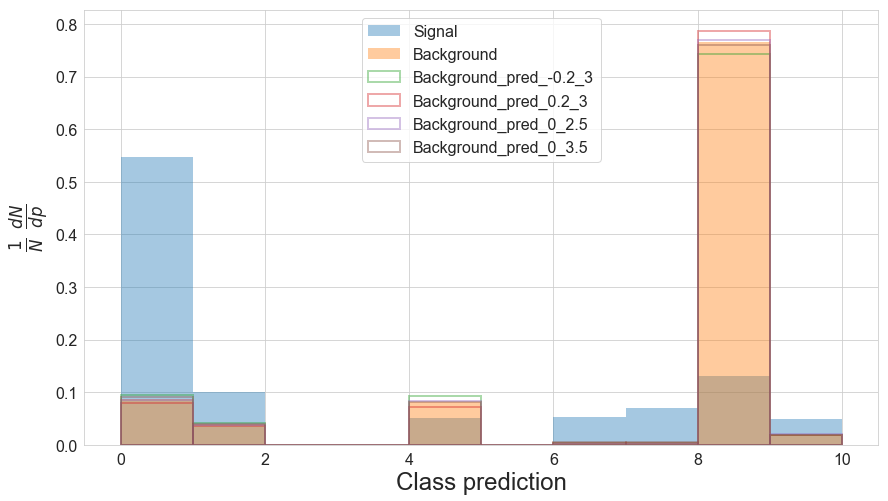

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([9.2086e-02, 4.1276e-02, 2.0000e-13, 2.0000e-13, 9.3642e-02, 2.0000e-13,
        2.1520e-03, 2.7980e-03, 7.4726e-01, 2.0782e-02])
tensor([9.5320e-02, 4.1996e-02, 2.0000e-13, 2.0000e-13, 9.2934e-02, 2.0000e-13,
        3.4540e-03, 4.2680e-03, 7.4253e-01, 1.9502e-02])
tensor([9.7630e-02, 4.2592e-02, 2.0000e-13, 2.0000e-13, 9.2556e-02, 2.0000e-13,
        5.2940e-03, 6.0220e-03, 7.3744e-01, 1.8466e-02])
tensor([8.4510e-02, 3.8244e-02, 2.0000e-13, 2.0000e-13, 8.2802e-02, 2.0000e-13,
        1.7600e-03, 2.4200e-03, 7.7016e-01, 2.0106e-02])
tensor([8.7744e-02, 3.8964e-02, 2.0000e-13, 2.0000e-13, 8.2094e-02, 2.0000e-13,
        3.0620e-03, 3.8900e-03, 7.6542e-01, 1.8826e-02])
tensor([9.0054e-02, 3.9560e-02, 2.0000e-13, 2.0000e-13, 8.1716e-02, 2.0000e-13,
        4.9020e-03, 5.6440e-03, 7.6033e-01, 1.7790e-02])
tensor([7.6862e-02, 3.5160e-02, 2.0000e-13, 2.0000e-13, 7.2960e-02, 2.0000e-13,
        1.5940e-03, 2.0480e-03, 7.9198e-01, 1.9396e-02])
tensor([8.0096e-02, 3.5880e-02, 2.0000e-1

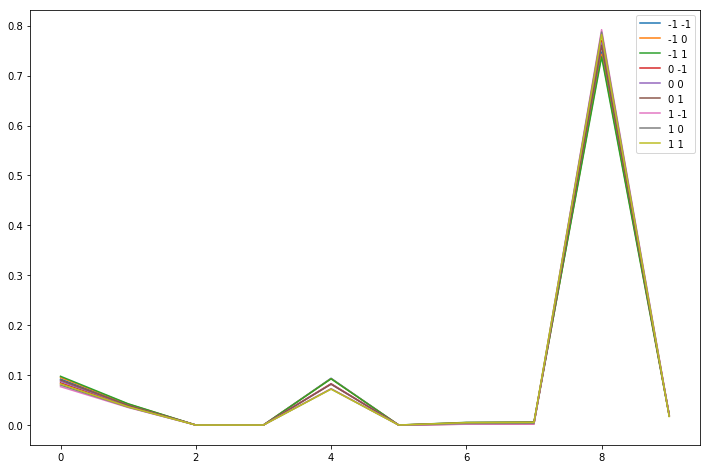

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [39]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

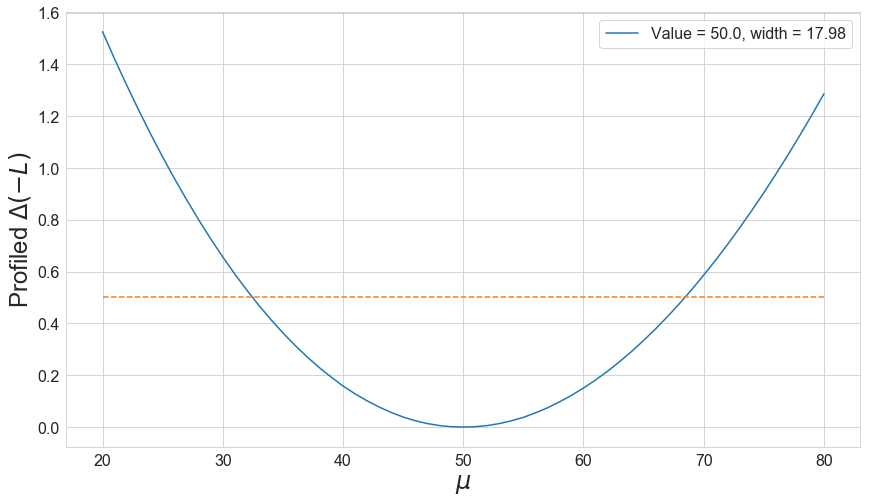

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.1451])
Linear regime: Mu 21.0, alpha tensor([1.1058])
Linear regime: Mu 22.0, alpha tensor([1.0666])
Linear regime: Mu 71.0, alpha tensor([-1.0145])
Linear regime: Mu 72.0, alpha tensor([-1.0626])
Linear regime: Mu 73.0, alpha tensor([-1.1106])
Linear regime: Mu 74.0, alpha tensor([-1.1586])
Linear regime: Mu 75.0, alpha tensor([-1.2066])
Linear regime: Mu 76.0, alpha tensor([-1.2546])
Linear regime: Mu 77.0, alpha tensor([-1.3026])
Linear regime: Mu 78.0, alpha tensor([-1.3505])
Linear regime: Mu 79.0, alpha tensor([-1.3984])
Linear regime: Mu 80.0, alpha tensor([-1.4463])


In [47]:
nll = to_np(nll)

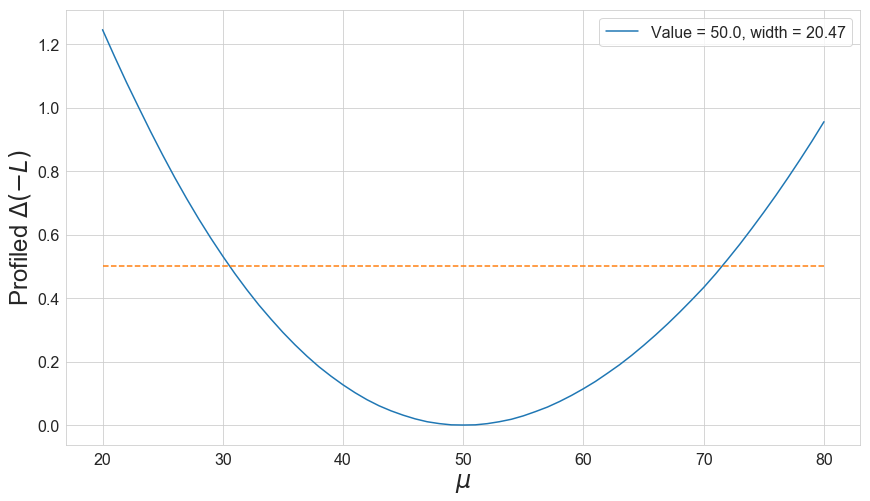

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 74.0, alpha tensor([ 0.3195, -1.0051])
Linear regime: Mu 75.0, alpha tensor([ 0.3326, -1.0472])
Linear regime: Mu 76.0, alpha tensor([ 0.3458, -1.0894])
Linear regime: Mu 77.0, alpha tensor([ 0.3589, -1.1315])
Linear regime: Mu 78.0, alpha tensor([ 0.3721, -1.1737])
Linear regime: Mu 79.0, alpha tensor([ 0.3852, -1.2159])
Linear regime: Mu 80.0, alpha tensor([ 0.3983, -1.2581])


In [50]:
nll = to_np(nll)

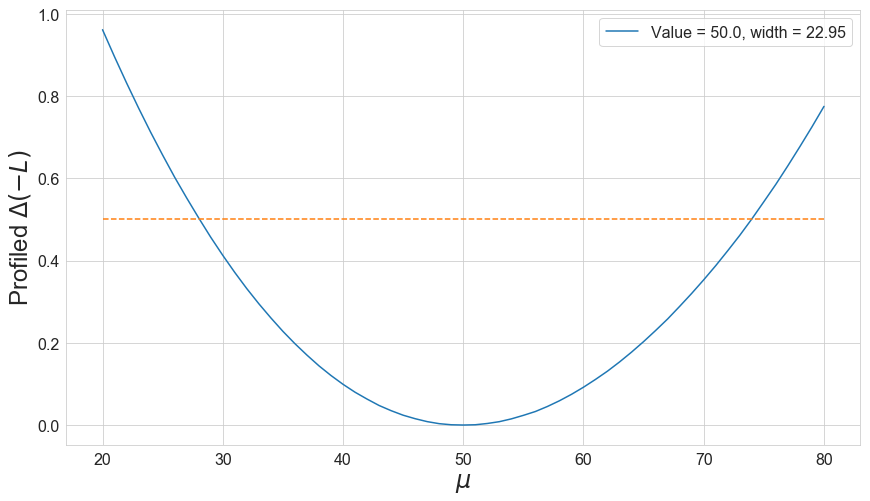

In [51]:
plot_likelihood(nll-nll.min())